In [1]:
import numpy
import numpy as np
import time
import datetime
import netCDF4
import matplotlib.pylab as plt
import os,sys,glob
# sys.path.append(os.getcwd()+'/../adjust/rasotools/')
# from utils import *
from multiprocessing import Pool
#import odb
from eccodes import *
from functools import partial
from collections import OrderedDict
import subprocess
import json
import gzip
import copy
import pickle
import xarray as xr

import pandas as pd
import matplotlib
import matplotlib.pylab as plt
import matplotlib.pyplot as maplt
matplotlib.rcParams.update({'font.size': 20})

plt.rcParams['lines.linewidth'] = 3

import warnings
warnings.filterwarnings('ignore')

sys.path.append(os.getcwd()+'/../cds-backend/code/')
import cds_eua3 as eua
sys.path.append(os.getcwd()+'/../')
import metutils as mu
import trajectory as trj
 

In [3]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [19]:
stat = '11035'
statlist = glob.glob('/mnt/users/scratch/leo/scratch/converted_v8/*' + stat + '*_CEUAS_merged_v1.nc')
file = eua.CDMDataset(filename = statlist[0])

In [52]:
df = file.to_dataframe(groups=['observations_table'], variables=['latitude', 'longitude', 'observed_variable', 'observation_value', 'z_coordinate', 'date_time', 'report_id'])
df_t = df[df.observed_variable == 126]

In [53]:
df_repid = file.to_dataframe(groups=['header_table'], variables=['report_id','date_time'])
df_repid

,report_id
0,30000000001
1,30000000002
2,30000000003
3,30000000004
4,30000000005
...,...
97509,10000056941
97510,10000056942
97511,10000056943
97512,10000056944


In [59]:
df_t.report_id.drop_duplicates()

40043490    80000000000
40043515    80000000001
40043542    80000000002
40043563    60000000016
40043572    60000000020
               ...     
49338484    10000056941
49340727    10000056942
49345933    10000056943
49348283    10000056944
49353586    10000056945
Name: report_id, Length: 50117, dtype: object

In [65]:
file.observations_table.observation_id[:]

array([[b'6', b'0', b'0', ..., b'0', b'0', b'4'],
       [b'6', b'0', b'0', ..., b'0', b'0', b'5'],
       [b'6', b'0', b'0', ..., b'2', b'7', b'1'],
       ...,
       [b'1', b'0', b'1', ..., b'8', b'6', b'3'],
       [b'1', b'0', b'1', ..., b'8', b'8', b'1'],
       [b'1', b'0', b'1', ..., b'8', b'9', b'9']], dtype='|S1')

In [67]:
file.observations_table

observations_table:

adjustment_id_____________________________________ : : (88072698,)
advanced_assimilation_feedback____________________ : : (88072698,)
advanced_homogenisation___________________________ : : (88072698,)
advanced_qc_______________________________________ : : (88072698,)
advanced_uncertainty______________________________ : : (88072698,)
bbox_max_latitude_________________________________ : : (88072698,)
bbox_max_longitude________________________________ : : (88072698,)
bbox_min_latitude_________________________________ : : (88072698,)
bbox_min_longitude________________________________ : : (88072698,)
code_table________________________________________ : : (88072698,)
conversion_flag___________________________________ : : (88072698,)
conversion_method_________________________________ : : (88072698,)
crs_______________________________________________ : : (88072698,)
data_policy_licence_______________________________ : : (88072698,)
date_time________________________________

In [71]:
file.header_table.report_id[:]

array([[b'3', b'0', b'0', ..., b'0', b'0', b'1'],
       [b'3', b'0', b'0', ..., b'0', b'0', b'2'],
       [b'3', b'0', b'0', ..., b'0', b'0', b'3'],
       ...,
       [b'1', b'0', b'0', ..., b'9', b'4', b'3'],
       [b'1', b'0', b'0', ..., b'9', b'4', b'4'],
       [b'1', b'0', b'0', ..., b'9', b'4', b'5']], dtype='|S1')

In [75]:
file.recordindices['126'][:]

array([40043490, 40043490, 40043490, ..., 49348283, 49353586, 49355889])

In [77]:
file.observations_table.report_id[49353586]

array([b'1', b'0', b'0', b'0', b'0', b'0', b'5', b'6', b'9', b'4', b'5'],
      dtype='|S1')

In [78]:
file.observations_table.report_id[49353587]

array([b'1', b'0', b'0', b'0', b'0', b'0', b'5', b'6', b'9', b'4', b'5'],
      dtype='|S1')

In [83]:
file.observations_table.date_time[49355888]

3849939201

In [102]:
import trajectory as trj

In [103]:
stat = '11035'
statlist = glob.glob('/mnt/users/scratch/leo/scratch/converted_v8/*' + stat + '*_CEUAS_merged_v1.nc')
file = eua.CDMDataset(filename = statlist[0])

igra_file = glob.glob('/scratch/das/federico/COP2_HARVEST_APRIL2022/igra2/*'+stat+'*')[0]
i_file = eua.CDMDataset(filename = igra_file)


In [109]:
failcount = 0
slat = file.observations_table.latitude[0]
slon = file.observations_table.longitude[0]
for i in range(len(file.header_table.report_id[:])-1):
    
    t_idx_s = file.recordindices['126'][i]
    t_idx_e = file.recordindices['126'][i+1]
    u_idx_s = file.recordindices['139'][i]
    u_idx_e = file.recordindices['139'][i+1]
    v_idx_s = file.recordindices['140'][i]
    v_idx_e = file.recordindices['140'][i+1]

    if (u_idx_s == u_idx_e) or (u_idx_s == u_idx_e) or (t_idx_s == t_idx_e):
        continue
        
    repid = file.header_table.report_id[i]
    u = file.observations_table.observation_value[u_idx_s:u_idx_e]
    v = file.observations_table.observation_value[v_idx_s:v_idx_e]
    t = file.observations_table.observation_value[t_idx_s:t_idx_e]
    z_coordinate = file.observations_table.z_coordinate[t_idx_s:t_idx_e]
    date_time = file.observations_table.date_time[t_idx_s]
#     print(repid)

#     print(pd.to_datetime(file.observations_table.date_time[t_idx_s], unit='s', origin='1900-01-01') )
#     print(pd.to_datetime(file.observations_table.date_time[t_idx_e], unit='s', origin='1900-01-01') )
#     print(pd.to_datetime(file.observations_table.date_time[t_idx_s+1], unit='s', origin='1900-01-01') )
#     print(pd.to_datetime(file.observations_table.date_time[t_idx_e-1], unit='s', origin='1900-01-01') )
    
    dt_date = pd.to_datetime(date_time, unit='s', origin='1900-01-01')
    
    #check if < 2013:
    if dt_date.year < 2013:
        #if not already igra data -> select igra datetime
        if int(repid[0]) != 3:
            dups = file.header_table.duplicates[i]
            dups = dups[dups != b'']
            dups = dups[dups != b',']
            #iterate through all duplicates
            for i in range(0,int((len(dups)/11))):
                #if there is an igra duplicate:
                if int((dups[(i*11):((i+1)*11)])[0]) == 3:
#                     print((dups[(i*11):((i+1)*11)]))
                    save_id = 0
                    deci = 1
                    a = ((dups[(i*11):((i+1)*11)]))[1:]
                    for i in np.flip(a):
                        save_id += int(i)* deci
                        deci = deci*10
                    # why -1? shouldn't it point on the correct time already?
                    dt_date = pd.to_datetime(i_file.recordtimestamp[save_id-1], unit='s', origin='1900-01-01')
#                     print('igra_time', pd.to_datetime(i_file.recordtimestamp[save_id-1], unit='s', origin='1900-01-01'))
#                     print('cuon time', dt_date)
                    print()
            failcount += 1
    print(np.array(u))
    phys_model = trj.trajectory(lat=slat, lon=slon, temperature=np.flip(t), u=np.flip(u), v=np.flip(v), pressure=np.flip(z_coordinate))
    print(phys_model[3])
    if failcount > 1000:
        break




[ 9.205049  14.728078  23.        22.252413  16.68931   16.
 16.        16.        15.5       15.        14.5       14.
 12.078418  10.206784   8.2595005  6.368313   7.0426044  7.679436
  8.316268   8.99056   11.833537  14.76394   17.64899   20.506096
 20.364674  20.152542  19.94041   19.79899   21.566757  23.334524
 25.102291  26.870058 ]
[ 0.         -1.76776695 -1.76776695 -1.76776695 -1.76776695  0.14142036
  0.2121315   0.2121315   0.14142227  0.45274734  0.44269943  0.39311981
  0.45774841 -1.66893005 -1.57621193 -1.57621384 -1.66893005 -3.9663353
 -3.90709114 -3.96418262 -3.92451596]
[ 3.535534   7.         5.563103   9.271839  15.762126  14.834942
 13.444166  12.0533905 13.907758  15.762126  17.616493  19.470861
 18.543678  17.616493  16.68931   15.762126  14.497484  13.196897
 11.940583  10.606602  13.496941  16.406137  19.340494  22.252413
 23.365034  24.570372  25.775711  26.888332  25.775711  24.570372
 23.365034  22.252413  25.219402  28.279108  31.338814  34.3058
 28.5949

IndexError: index 4 is out of bounds for axis 0 with size 4

In [ ]:
%debug

> /mnt/users/staff/a1400070/CEUAS/CEUAS/public/trajectory/trajectory.py(198)trajectory()
    196 #                 case _:
    197 #                     print('error: not a valid wind request')
--> 198             u_shear.append(u[i]-u[i-1])
    199             v_shear.append(v[i]-v[i-1])
    200 #             if (u_factor != 1) or (v_factor != 1):



ipdb>  print(u)


[28. 19. 19. 16.]


ipdb>  print(v)


[0. 0. 0. 0.]


ipdb>  print(t)


*** NameError: name 't' is not defined


ipdb>  print(temperature)


[282.65 285.15 282.35 280.35 268.95 265.95 256.35 254.15 251.95 242.95
 233.15 227.65 220.95]


In [86]:
a

array([b'7', b'0', b'0', b'0', b'0', b'0', b'0', b'0', b'3', b'2', b'6'],
      dtype='|S1')

In [88]:
a = a[1:]

326


In [94]:
a

array([b'0', b'0', b'0', b'0', b'0', b'0', b'0', b'3', b'2', b'6'],
      dtype='|S1')

In [79]:
pd.to_datetime(i_file.recordtimestamp[941-1], unit='s', origin='1900-01-01')

Timestamp('1949-06-21 03:00:00')

In [69]:
pd.to_datetime(i_file.recordtimestamp[1], unit='s', origin='1900-01-01')

Timestamp('1910-01-28 11:19:00')

In [78]:
i_file.recordindex[:]

array([       0,       30,       96, ..., 22074804, 22075038, 22075668])

In [80]:
i_file.recordtimestamp[:]

array([ 316016520,  317906340,  317918160, ..., 3778833600, 3778876800,
       3833308800])

In [94]:
igra_file.header_table.report_id[:]

array([[b'n', b'a', b'n', ..., b'', b'', b''],
       [b'n', b'a', b'n', ..., b'', b'', b''],
       [b'n', b'a', b'n', ..., b'', b'', b''],
       ...,
       [b'n', b'a', b'n', ..., b'', b'', b''],
       [b'n', b'a', b'n', ..., b'', b'', b''],
       [b'n', b'a', b'n', ..., b'', b'', b'']], dtype='|S1')

In [99]:
file.header_table.duplicates[0]

array([b'8', b'0', b'0', b'0', b'0', b'0', b'0', b'0', b'0', b'0', b'0',
       b',', b'3', b'0', b'0', b'0', b'0', b'0', b'0', b'0', b'0', b'0',
       b'1', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'',
       b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'',
       b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'',
       b'', b'', b'', b'', b'', b'', b'', b'', b''], dtype='|S1')

In [26]:
glob.glob('/scratch/das/federico/COP2_HARVEST_APRIL2022/igra2/*'+stat+'*')

['/scratch/das/federico/COP2_HARVEST_APRIL2022/igra2/0-20001-0-11035_igra2_harvested_AUM00011035-data.txt.nc']

In [15]:
igra_file = eua.CDMDataset(filename = glob.glob('/scratch/das/federico/COP2_HARVEST_APRIL2022/igra2/*'+stat+'*')[0])

In [23]:
igra_df = igra_file.to_dataframe(groups=['observations_table'], variables=['latitude', 'longitude', 'observed_variable', 'observation_value', 'z_coordinate', 'date_time'])
igra_df_t = igra_df[igra_df.observed_variable == 126]

In [24]:
igra_df_t[~np.isnan(igra_df_t.observation_value)]

,latitude,longitude,observed_variable,observation_value,z_coordinate,date_time
43093,48.2486,16.3564,126,226.649994,32000.0,1949-02-08 04:00:00
43099,48.2486,16.3564,126,236.649994,40000.0,1949-02-08 04:00:00
43105,48.2486,16.3564,126,240.649994,43000.0,1949-02-08 04:00:00
43111,48.2486,16.3564,126,248.649994,50000.0,1949-02-08 04:00:00
43117,48.2486,16.3564,126,251.649994,52300.0,1949-02-08 04:00:00
...,...,...,...,...,...,...
22076467,48.2486,16.3564,126,294.950012,89500.0,2021-06-22 00:00:00
22076479,48.2486,16.3564,126,294.350006,92500.0,2021-06-22 00:00:00
22076485,48.2486,16.3564,126,294.350006,92900.0,2021-06-22 00:00:00
22076497,48.2486,16.3564,126,295.750000,97300.0,2021-06-22 00:00:00


In [35]:
igra_df_t[igra_df_t.date_time.dt.year == 1949][igra_df_t.date_time.dt.month == 2][igra_df_t.date_time.dt.day == 8]

,latitude,longitude,observed_variable,observation_value,z_coordinate,date_time
43093,48.2486,16.3564,126,226.649994,32000.0,1949-02-08 04:00:00
43099,48.2486,16.3564,126,236.649994,40000.0,1949-02-08 04:00:00
43105,48.2486,16.3564,126,240.649994,43000.0,1949-02-08 04:00:00
43111,48.2486,16.3564,126,248.649994,50000.0,1949-02-08 04:00:00
43117,48.2486,16.3564,126,251.649994,52300.0,1949-02-08 04:00:00
43123,48.2486,16.3564,126,259.950012,59200.0,1949-02-08 04:00:00
43129,48.2486,16.3564,126,268.149994,70000.0,1949-02-08 04:00:00
43135,48.2486,16.3564,126,274.350006,84400.0,1949-02-08 04:00:00
43141,48.2486,16.3564,126,273.649994,85000.0,1949-02-08 04:00:00
43147,48.2486,16.3564,126,273.350006,85800.0,1949-02-08 04:00:00


In [37]:
df_t[df_t.date_time.dt.year == 1949]#[df_t.date_time.dt.month == 2][df_t.date_time.dt.day == 8]

,latitude,longitude,observed_variable,observation_value,z_coordinate,date_time
40043563,48.32,16.120001,126,229.350006,36500.0,1949-04-08 03:00:00
40043564,48.32,16.120001,126,232.350006,40000.0,1949-04-08 03:00:00
40043565,48.32,16.120001,126,239.149994,50000.0,1949-04-08 03:00:00
40043566,48.32,16.120001,126,249.949997,60000.0,1949-04-08 03:00:00
40043567,48.32,16.120001,126,260.149994,70000.0,1949-04-08 03:00:00
...,...,...,...,...,...,...
40045429,48.32,16.120001,126,262.649994,73800.0,1949-12-31 03:00:00
40045430,48.32,16.120001,126,260.950012,77200.0,1949-12-31 03:00:00
40045431,48.32,16.120001,126,266.649994,85000.0,1949-12-31 03:00:00
40045432,48.32,16.120001,126,272.649994,93400.0,1949-12-31 03:00:00


In [40]:
igra_df_t[igra_df_t.date_time.dt.year == 1970][igra_df_t.date_time.dt.month == 2][igra_df_t.date_time.dt.day == 8]

,latitude,longitude,observed_variable,observation_value,z_coordinate,date_time
1727335,48.2486,16.3564,126,237.250000,600.0,1970-02-08 00:00:00
1727341,48.2486,16.3564,126,222.050003,1000.0,1970-02-08 00:00:00
1727347,48.2486,16.3564,126,213.050003,1300.0,1970-02-08 00:00:00
1727353,48.2486,16.3564,126,217.850006,1800.0,1970-02-08 00:00:00
1727359,48.2486,16.3564,126,215.649994,2000.0,1970-02-08 00:00:00
...,...,...,...,...,...,...
1727773,48.2486,16.3564,126,264.250000,76200.0,1970-02-08 12:00:00
1727779,48.2486,16.3564,126,271.250000,85000.0,1970-02-08 12:00:00
1727785,48.2486,16.3564,126,272.250000,86200.0,1970-02-08 12:00:00
1727791,48.2486,16.3564,126,274.750000,92000.0,1970-02-08 12:00:00


In [41]:
df_t[df_t.date_time.dt.year == 1970][df_t.date_time.dt.month == 2][df_t.date_time.dt.day == 8]

,latitude,longitude,observed_variable,observation_value,z_coordinate,date_time
40381132,48.25,16.370001,126,237.300003,600.0,1970-02-08 00:00:00
40381133,48.25,16.370001,126,222.100006,1000.0,1970-02-08 00:00:00
40381134,48.25,16.370001,126,213.100006,1300.0,1970-02-08 00:00:00
40381135,48.25,16.370001,126,217.899994,1800.0,1970-02-08 00:00:00
40381136,48.25,16.370001,126,215.699997,2000.0,1970-02-08 00:00:00
...,...,...,...,...,...,...
40381195,48.25,16.370001,126,264.299988,76200.0,1970-02-08 12:00:00
40381196,48.25,16.370001,126,271.299988,85000.0,1970-02-08 12:00:00
40381197,48.25,16.370001,126,272.299988,86200.0,1970-02-08 12:00:00
40381198,48.25,16.370001,126,274.799988,92000.0,1970-02-08 12:00:00


In [33]:
pd.Timestamp('1949-02-08').day

8

In [8]:
file.header_table.report_id[0]

array([b'3', b'0', b'0', b'0', b'0', b'0', b'0', b'0', b'0', b'0', b'1'],
      dtype='|S1')

In [10]:
file.observations_table.report_id[0]

array([b'6', b'0', b'0', b'0', b'0', b'0', b'0', b'0', b'0', b'1', b'6'],
      dtype='|S1')

In [11]:
df = file.to_dataframe(
    groups=['observations_table', 'era5fb',], 
    variables=['latitude', 'longitude', 'observed_variable',
               'observation_value', 'z_coordinate', 'date_time',
               'fg_depar@body', 'an_depar@body', 'report_id'],
    
)

In [12]:
df

,latitude,longitude,observed_variable,observation_value,z_coordinate,date_time,report_id,fg_depar@body,an_depar@body
0,48.320000,16.120001,0,98300.000000,NaN,1949-04-08 03:00:00,60000000016,0.000000,0.000000
1,48.320000,16.120001,0,98300.000000,NaN,1949-04-08 03:00:00,60000000016,0.000000,0.000000
2,48.320000,16.120001,0,99300.000000,NaN,1949-04-12 03:00:00,60000000020,0.000000,0.000000
3,48.320000,16.120001,0,99300.000000,NaN,1949-04-12 03:00:00,60000000020,0.000000,0.000000
4,48.320000,16.120001,0,99100.000000,NaN,1949-04-13 03:00:00,60000000021,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
67784821,48.248772,16.357679,140,-0.291076,97310.0,2020-12-29 13:16:08,10000056179,-2.183560,-2.935349
67784822,48.248951,16.357180,140,0.088295,97780.0,2020-12-29 23:32:03,10000056180,-0.477231,-1.535151
67784823,48.248951,16.357180,140,-0.000000,98100.0,2020-12-30 11:30:08,10000056181,1.442932,0.178675
67784824,48.248951,16.357180,140,-0.113302,98550.0,2020-12-30 23:31:43,10000056182,0.491889,0.944099


# Calculate the trajectory RMSE

In [3]:
def trajectory_rmse (stats, year, month=False, time=False, show_ascents=False, show_date=False, min_disp=0, compare_to='fc', diff=False):
    print('compare to: ', compare_to)
    for stat in stats:
        statlist = glob.glob('/mnt/users/scratch/leo/scratch/converted_v7/*' + stat + '*_CEUAS_merged_v1.nc')
        df = eua.CDMDataset(filename = statlist[0]).to_dataframe(groups=['observations_table', 'era5fb'], variables=['latitude', 'longitude', 'observed_variable', 'observation_value', 'z_coordinate', 'date_time', 'fg_depar@body', 'an_depar@body'])
        # 2020 only
        df = df[df.date_time.dt.year == year]
        # night only -> ~ 00:00
        if time:
            df = df[np.isin(df.date_time.dt.hour,time)]

        from scipy.signal import savgol_filter
        # stdplevs = [92500,85000,70000,50000,40000,30000,25000,20000,15000,10000,7000,5000,3000,2000,1000]
        stdplevs = [1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000,92500]
        rmse_sum_shbase_sonde={}
        rmse_sum_shbase_adjsonde={}
        rmse_sum_shdisp_sonde={}
        rmse_sum_shdisp_adjsonde={}
        rms_sum_shbase={}
        rms_sum_adjsonde={}
        rms_sum_sonde={}
        rms_sum_shdisp={}
        rms_sum_dispminusbase={}

        for i in stdplevs:
            rmse_sum_shbase_sonde[i] = []
            rmse_sum_shbase_adjsonde[i] = []
            rmse_sum_shdisp_sonde[i] = []
            rmse_sum_shdisp_adjsonde[i] = []
            rms_sum_shbase[i] = []
            rms_sum_adjsonde[i] = []
            rms_sum_sonde[i] = []
            rms_sum_shdisp[i] = []
            rms_sum_dispminusbase[i] = []
        
        if month == False:
            month = [1,2,3,4,5,6,7,8,9,10,11,12]
        else:
            month = [month]
        for m in month:
            if compare_to == 'fc':
                files = glob.glob('/mnt/scratch/scratch/leo/scratch/era5/gridded/era5fct.'+str(year)+str(m).zfill(2)+'*.133.nc')[0]
            else:
                files = glob.glob('/mnt/scratch/scratch/leo/scratch/era5/gridded/era5t.'+str(year)+str(m).zfill(2)+'*.133.nc')[0]
            ds_fc = xr.load_dataset(files)
            
            df_mon = df[df.date_time.dt.month == m]
            
            for day in df_mon.date_time.drop_duplicates()[:]:
                try:
                    test = df_mon[df_mon.date_time == day]
                    if show_date:
                        print(day)

                    t = test[test.observed_variable == 85]
                    t = t.rename(columns={'observation_value':'temperature'})
                    t = t.drop(columns='observed_variable')
                    
                    q = test[test.observed_variable == 38]
                    q = q.rename(columns={'observation_value':'rh'})
                    q = q.drop(columns='observed_variable')

                    u = test[test.observed_variable == 104]
                    u = u.rename(columns={'observation_value':'u'})
                    u = u.drop(columns=['observed_variable', 'fg_depar@body', 'an_depar@body'])

                    v = test[test.observed_variable == 105]
                    v = v.rename(columns={'observation_value':'v'})
                    v = v.drop(columns=['observed_variable', 'fg_depar@body', 'an_depar@body'])

                    input_data = pd.merge(t, u, on=['z_coordinate', 'latitude', 'longitude', 'date_time'])
                    input_data = pd.merge(input_data, v, on=['z_coordinate', 'latitude', 'longitude', 'date_time'])
                    input_data = pd.merge(input_data, q, on=['z_coordinate', 'latitude', 'longitude', 'date_time'])

                    input_data = input_data.dropna()
                    input_data = input_data.reindex(index=input_data.index[::-1])
                    phys_model = trj.trajectory(lat=t.latitude.iloc[0], lon=t.longitude.iloc[0], temperature=np.array(input_data.temperature), u=np.array(input_data.u), v=np.array(input_data.v), pressure=np.array(input_data.z_coordinate))
                    if (np.abs(np.nanmax(phys_model[0])) < min_disp) and (np.abs(np.nanmax(phys_model[1])) < min_disp):
        #                 print(np.nanmax(phys_model[0]), np.nanmax(phys_model[1]))
                        continue
                    input_data['z'] = np.array(trj.calc_height(np.array(input_data.temperature), np.array(input_data.z_coordinate), jump=False))
                    input_data['calc_latd'] = np.array(phys_model[0])
                    input_data['calc_lond'] = np.array(phys_model[1])
                    input_data = input_data.reindex(index=input_data.index[::-1])
                    input_data = input_data.reset_index()

                    ds_fc_time = ds_fc.sel(time=day, method='nearest')
        #                 display(ds_fc_time)
                #     ds_fc_loc = ds_fc_time.interp(latitude=search_lat, longitude=search_lon, method='linear')
                #     df_fc_loc = ds_fc_loc.to_dataframe()

                #     display(input_data)
                    t_list = []
                    for i in np.array(ds_fc_time.level): #10,20,...,1000
                        step = find_nearest(input_data.z_coordinate, i*100)
                #         print('step - level: ', step)
                        input_data_step = input_data[input_data.z_coordinate == step]
                #         print('displacement: ', input_data_step.calc_latd)
                        station_lat = input_data.latitude[0] + np.array(input_data_step.calc_latd)[0]
                #         print(i, input_data.latitude[0], station_lat)
                        station_lon = input_data.longitude[0] + np.array(input_data_step.calc_lond)[0]
                #         print(i, input_data.longitude[0], station_lon)
                        lon = station_lon
                        if lon < 0:
                            lon = 360.+lon
                        ds_now = ds_fc_time.interp(latitude=[station_lat], longitude=[lon], method="linear")
                #         print('selected lat: ', float(ds_now.latitude))
                        t = ds_now.q.sel(level = i)
                        t_list.append(float(t))

                #     print('lat: ', input_data.latitude[0], 'lon: ', input_data.longitude[0])
                #     print(stat)
                #     print(day)
                    p_ml = [  1000,   2000,   3000,   5000,   7000,  10000,  15000,  20000,  25000,  30000,  40000,  50000,  70000,  85000,  92500, 100000]
                    lon = input_data.longitude[0]
                    if lon < 0:
                        lon = 360.+lon
                    base_t = np.array(ds_fc_time.interp(latitude=[input_data.latitude[0]], longitude=[lon], method="linear").q)
                    for i in range(len(stdplevs)):
                        if np.abs(stdplevs[i] - find_nearest(input_data.z_coordinate,stdplevs[i])) > 500:
#                             print(stdplevs[i] , find_nearest(p_ml,stdplevs[i]))
                            rmse_sum_shbase_sonde[stdplevs[i]].append(np.nan)
                            rmse_sum_shbase_adjsonde[stdplevs[i]].append(np.nan)
                            rmse_sum_shdisp_sonde[stdplevs[i]].append(np.nan)
                            rmse_sum_shdisp_adjsonde[stdplevs[i]].append(np.nan)
                            rms_sum_shbase[stdplevs[i]].append(np.nan)
                            rms_sum_adjsonde[stdplevs[i]].append(np.nan)
                            rms_sum_sonde[stdplevs[i]].append(np.nan)
                            rms_sum_shdisp[stdplevs[i]].append(np.nan)
                            rms_sum_dispminusbase[stdplevs[i]].append(np.nan)

                        else:
                            sq_t = np.squeeze(base_t)
                            
                            input_data_step = input_data[input_data.z_coordinate == find_nearest(input_data.z_coordinate, stdplevs[i])]
                            t_sonde = float(input_data_step.rh)
                #             t_adjsonde = float(input_data_step.temperature) - float(input_data_step['fg_depar@body']) - float(input_data_step['an_depar@body'])
                            t_adjsonde = float(input_data_step.rh)# - float(input_data_step['an_depar@body'])
                    
                            t_base = float(sq_t[p_ml == find_nearest(p_ml,stdplevs[i])])
                            t_base = mu.spHumToRH(t_base, float(input_data_step.temperature)-273.15, stdplevs[i]/1000.)/10.
                            t_disp = float(np.array(t_list)[p_ml == find_nearest(p_ml,stdplevs[i])])
                            t_disp = mu.spHumToRH(t_disp, float(input_data_step.temperature)-273.15, stdplevs[i]/1000.)/10.


                            rmse_sum_shbase_sonde[stdplevs[i]].append(t_base - t_sonde)
                            rmse_sum_shbase_adjsonde[stdplevs[i]].append(t_base - t_adjsonde)
                            rmse_sum_shdisp_sonde[stdplevs[i]].append(t_disp - t_sonde)
                            rmse_sum_shdisp_adjsonde[stdplevs[i]].append(t_disp - t_adjsonde)
                            rms_sum_shbase[stdplevs[i]].append(t_base)
                            rms_sum_adjsonde[stdplevs[i]].append(t_adjsonde)
                            rms_sum_sonde[stdplevs[i]].append(t_sonde)
                            rms_sum_shdisp[stdplevs[i]].append(t_disp)
                            rms_sum_dispminusbase[stdplevs[i]].append(t_disp-t_base)


                    if show_ascents:
                        fig, ax1 = maplt.subplots(1, figsize=(16, 8))
                        ax1.plot(np.squeeze(base_t), np.array(p_ml), color = 'green', alpha = 0.6, label='base rh')
                        ax1.plot(np.array(t_list), np.array(p_ml), color = 'blue', alpha = 0.2,ls = '--', label='displaced rh')
                        plt_sonde_t = []
                        for pl in stdplevs:
                            apl = find_nearest(input_data.z_coordinate, pl)
                            plt_sonde_t.append(float(input_data[input_data.z_coordinate == apl].rh))
                        ax1.plot(np.array(plt_sonde_t), np.array(stdplevs), color = 'red', alpha = 0.2,ls = '--', label='rh radio sonde')
    #                         ax1.plot(np.array(input_data.temperature), np.array(input_data.z_coordinate), color = 'red', alpha = 0.2,ls = '--', label='temperature radio sonde')
                    #     ax1.plot(np.array(input_data.temperature - input_data['an_depar@body'] ), np.array(input_data.z_coordinate), color = 'orange', alpha = 0.6, label='temperature radio sonde - an_depar')
                        ax1.set_ylabel('pressure (Pa)')
                        ax1.set_xlabel('rh')
                        ax1.tick_params(axis='y')
                        ax1.set_ylim(ax1.get_ylim()[::-1])
                        ax1.legend()
                        ax1.grid()
                        maplt.show()
                        maplt.close()
                except:
                    pass
            
        print('valid ascents: ', len(rms_sum_shdisp[50000]))

        rmse_shbase_sonde=[]
        rmse_shbase_adjsonde=[]
        rmse_shdisp_sonde=[]
        rmse_shdisp_adjsonde=[]

        rms_shbase=[]
        rms_adjsonde=[]
        rms_sonde=[]
        rms_shdisp=[]
        rms_dispmbase=[]

        for i in range(len(stdplevs)):
            rmse_shbase_sonde.append(np.sqrt(np.nanmean((np.array(rmse_sum_shbase_sonde[stdplevs[i]])**2))))
            if show_date:    
                print('rmse_shbase_sonde - plev: ', stdplevs[i], ' RMSE: ', rmse_shbase_sonde[-1])
            rmse_shbase_adjsonde.append(np.sqrt(np.nanmean((np.array(rmse_sum_shbase_adjsonde[stdplevs[i]])**2))))
            if show_date:    
                print('rmse_shbase_adjsonde - plev: ', stdplevs[i], ' RMSE: ', rmse_shbase_adjsonde[-1])
            rmse_shdisp_sonde.append(np.sqrt(np.nanmean((np.array(rmse_sum_shdisp_sonde[stdplevs[i]])**2))))
            if show_date:    
                print('rmse_shdisp_sonde - plev: ', stdplevs[i], ' RMSE: ', rmse_shdisp_sonde[-1])
            rmse_shdisp_adjsonde.append(np.sqrt(np.nanmean((np.array(rmse_sum_shdisp_adjsonde[stdplevs[i]])**2))))
            if show_date:    
                print('rmse_shdisp_adjsonde - plev: ', stdplevs[i], ' RMSE: ', rmse_shdisp_adjsonde[-1])

            rms_shbase.append(np.sqrt(np.nanmean((np.array(rms_sum_shbase[stdplevs[i]])**2))))
            if show_date:    
                print('rms_shbase - plev: ', stdplevs[i], ' RMS: ', rms_shbase[-1])
            rms_adjsonde.append(np.sqrt(np.nanmean((np.array(rms_sum_adjsonde[stdplevs[i]])**2))))
            if show_date:    
                print('rms_adjsonde - plev: ', stdplevs[i], ' RMS: ', rms_adjsonde[-1])
            rms_sonde.append(np.sqrt(np.nanmean((np.array(rms_sum_sonde[stdplevs[i]])**2))))
            if show_date:    
                print('rms_sonde - plev: ', stdplevs[i], ' RMS: ', rms_sonde[-1])
            rms_shdisp.append(np.sqrt(np.nanmean((np.array(rms_sum_shdisp[stdplevs[i]])**2))))
            if show_date:
                print('rms_shdisp - plev: ', stdplevs[i], ' RMS: ', rms_shdisp[-1])
            rms_dispmbase.append(np.sqrt(np.nanmean((np.array(rms_sum_dispminusbase[stdplevs[i]])**2))))
            if show_date:
                print('rms_dispmbase - plev: ', stdplevs[i], ' RMS: ', rms_shdisp[-1])


        print('')

        fig, ax1 = maplt.subplots(figsize = (15,10))
        ax1.plot(np.array(rmse_shbase_sonde),stdplevs,color='orange', label='rmse_base_sonde')
        ax1.plot(np.array(rmse_shdisp_sonde),stdplevs, color='red', label='rmse_disp_sonde')
#         ax1.plot(np.array(rmse_shbase_sonde)-np.array(rmse_shdisp_sonde),stdplevs,color='purple', label='diff')
#         ax1.plot(np.array(rms_dispmbase),stdplevs, color='green', alpha=0.3, ls='--', label='rms_disp_minus_base')
        
        ax1_4 = ax1.twiny()
        ax1_4.axvline(x=0, color='black', alpha=0.8, ls='--', lw=0.5)
        if diff:
            ax1_4.plot(np.array(rmse_shbase_sonde)-np.array(rmse_shdisp_sonde),stdplevs,color='purple', label='diff')
        ax1_4.plot(np.array(rms_dispmbase),stdplevs, color='green', alpha=0.3, ls='--', label='rms_disp_minus_base')

#         ax1_4.plot(np.array(rms_shdisp),stdplevs,color='grey', label='rms_shdisp')
#         ax1_4.plot(np.array(rms_shbase),stdplevs,color='grey',alpha=0.3, label='rms_shbase')
        ax1_4.legend(loc='lower left')
        ax1.set_ylim(ax1.get_ylim()[::-1])
        ax1.set_ylabel('pressure (Pa)')
        ax1.set_xlabel('relative humidity RMSE')
        ax1.legend(loc='upper right')
        ax1.grid()

        maplt.title(str(stat)+' LEVEL relative humidity RMSE')
        maplt.show()
        maplt.close()

compare to:  fc
valid ascents:  234



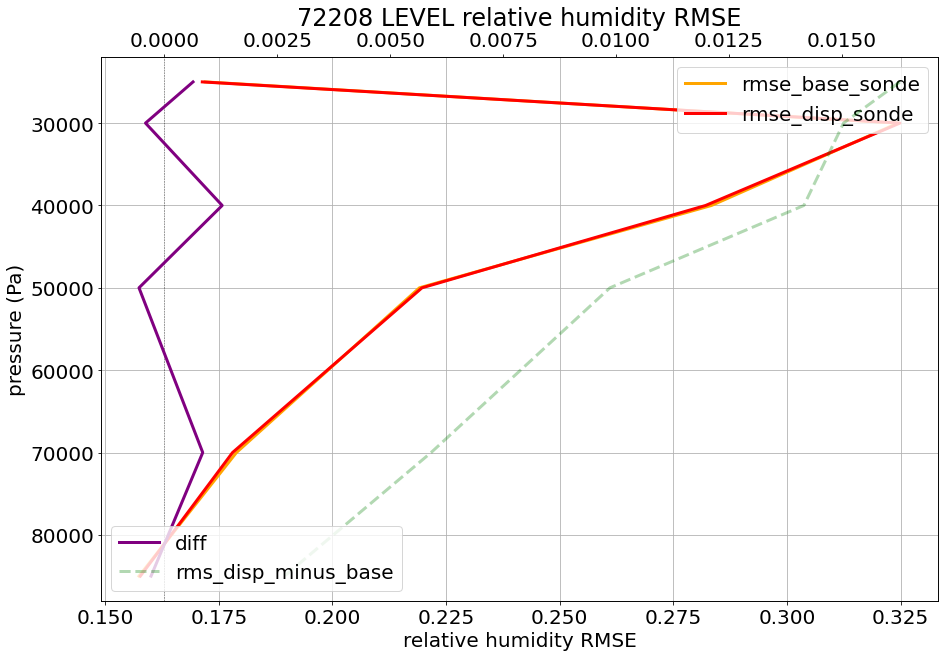

In [18]:
# east
stats = ['72208']
year = 1950
time = [15]
month = False
trajectory_rmse (stats=stats, year=year, month=month, time=time, show_ascents=False, show_date=False, min_disp=0,compare_to='fc', diff=True)

compare to:  fc
valid ascents:  124



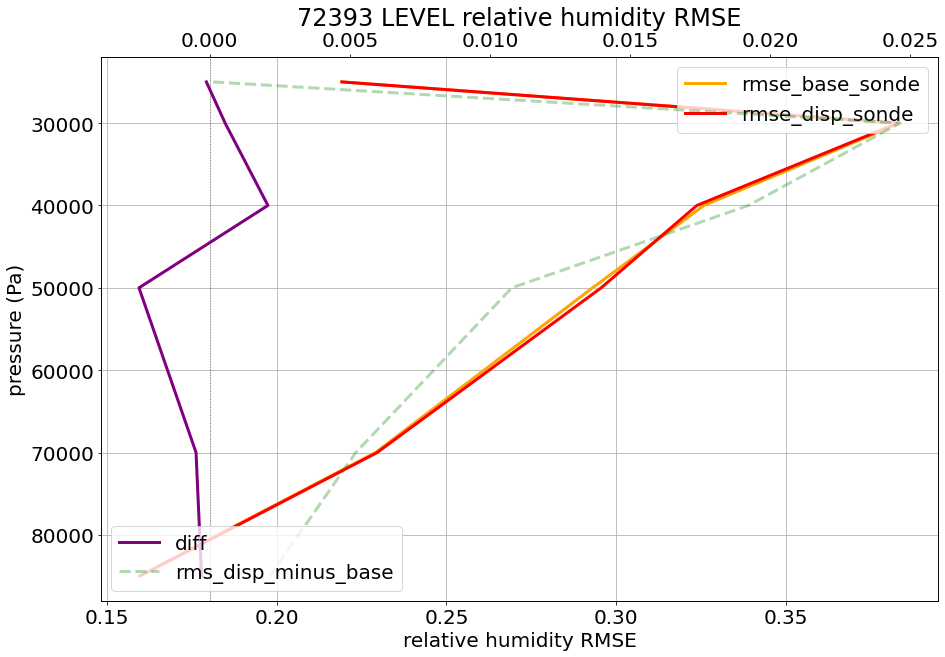

In [19]:
# west
stats = ['72393']
year = 1950
time = [15]
month = False
trajectory_rmse (stats=stats, year=year, month=month, time=time, show_ascents=False, show_date=False, min_disp=0,compare_to='fc', diff=True)

compare to:  fc
valid ascents:  614



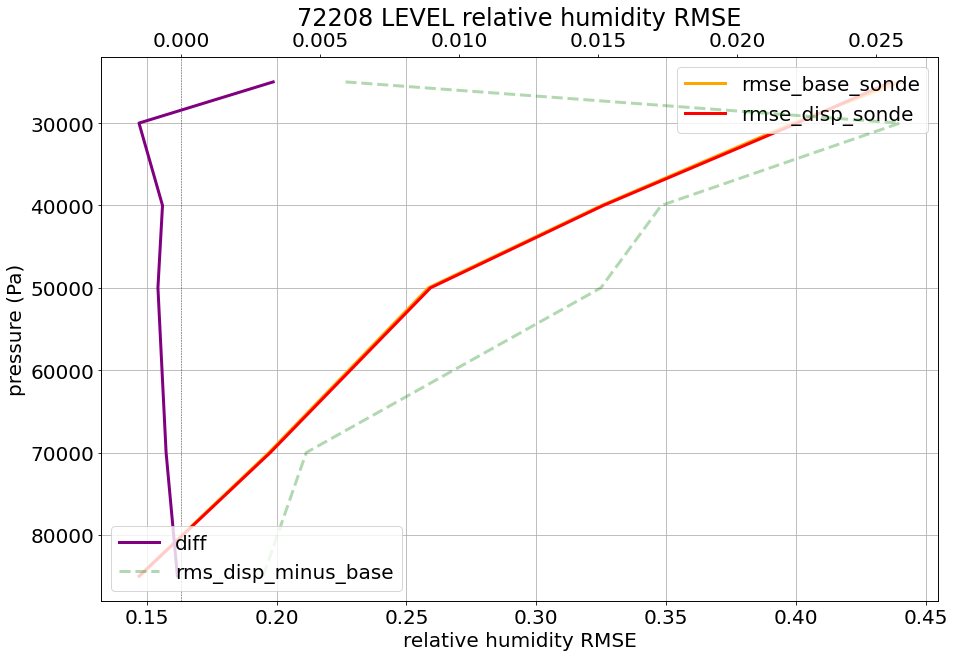

In [20]:
# east
stats = ['72208']
year = 1960
time = False
month = False
trajectory_rmse (stats=stats, year=year, month=month, time=time, show_ascents=False, show_date=False, min_disp=0,compare_to='fc', diff=True)

compare to:  fc
valid ascents:  928



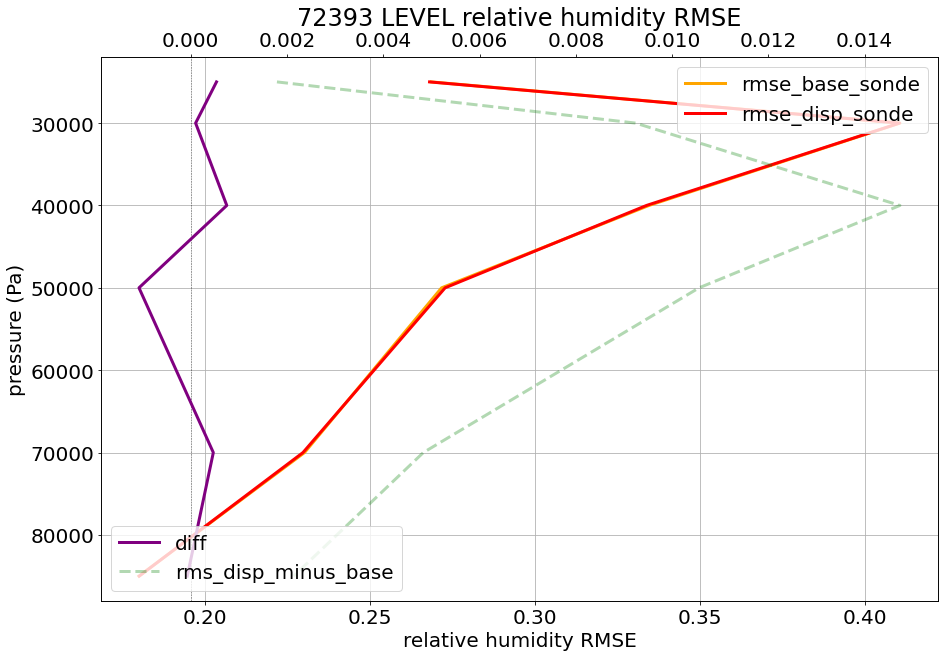

In [21]:
# west
stats = ['72393']
year = 1960
time = False
month = False
trajectory_rmse (stats=stats, year=year, month=month, time=time, show_ascents=False, show_date=False, min_disp=0,compare_to='fc', diff=True)

# Forecast

compare to:  fc
valid ascents:  364



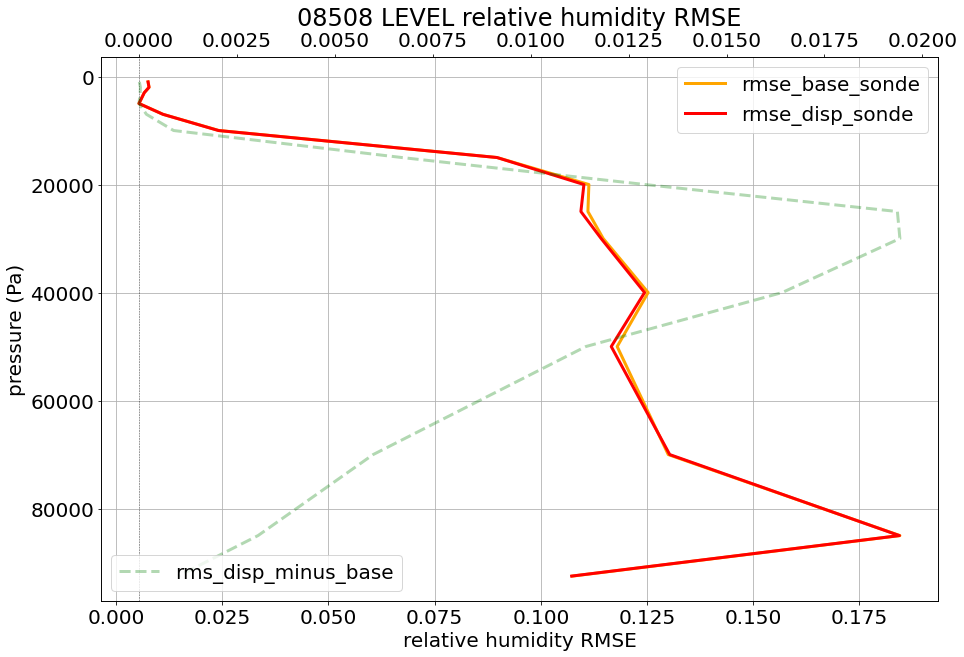

In [4]:
stats = ['08508']
year = 2020
time = [11,12,13]
month = False
trajectory_rmse (stats=stats, year=year, month=month, time=time, show_ascents=False, show_date=False, min_disp=0,compare_to='fc')


compare to:  fc
valid ascents:  361



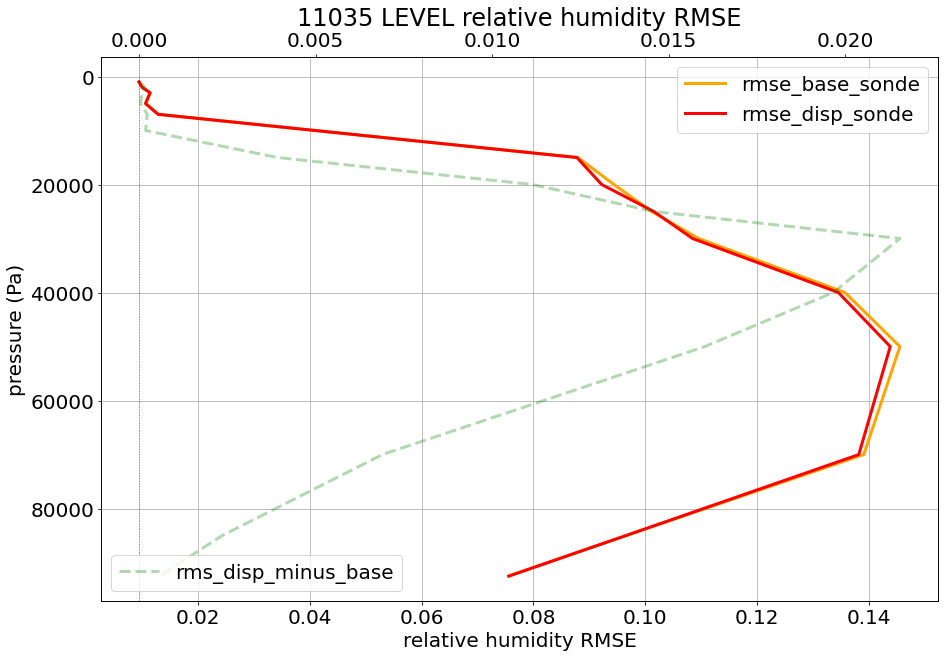

In [5]:
stats = ['11035']
year = 2020
time = [11,12,13]
month = False
trajectory_rmse (stats=stats, year=year, month=month, time=time, show_ascents=False, show_date=False, min_disp=0,compare_to='fc')

compare to:  fc
valid ascents:  362



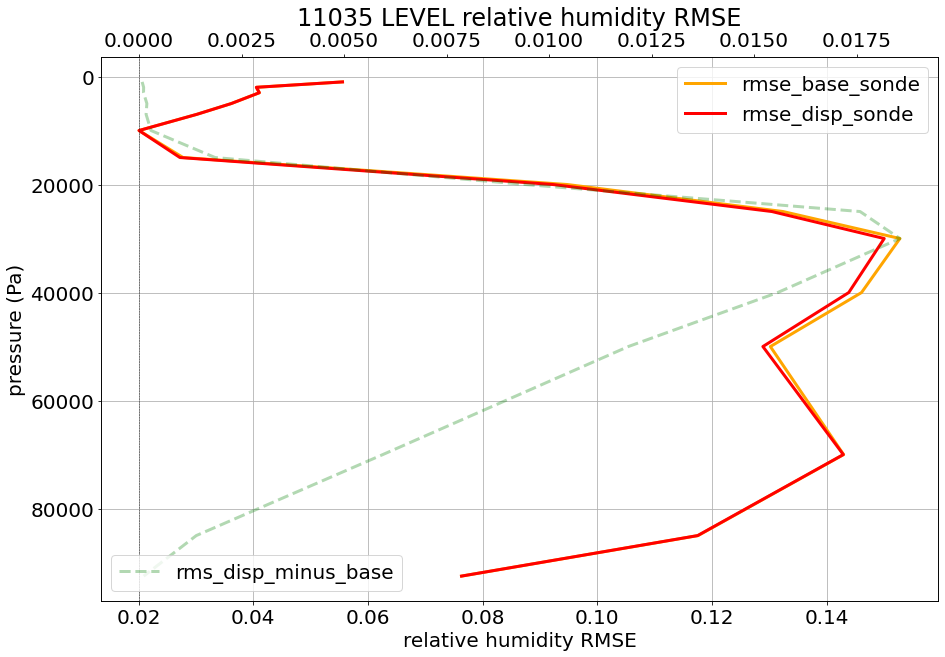

In [6]:
stats = ['11035']
year = 2010
time = [11,12,13]
month = False
trajectory_rmse (stats=stats, year=year, month=month, time=time, show_ascents=False, show_date=False, min_disp=0,compare_to='fc')

compare to:  fc
valid ascents:  355



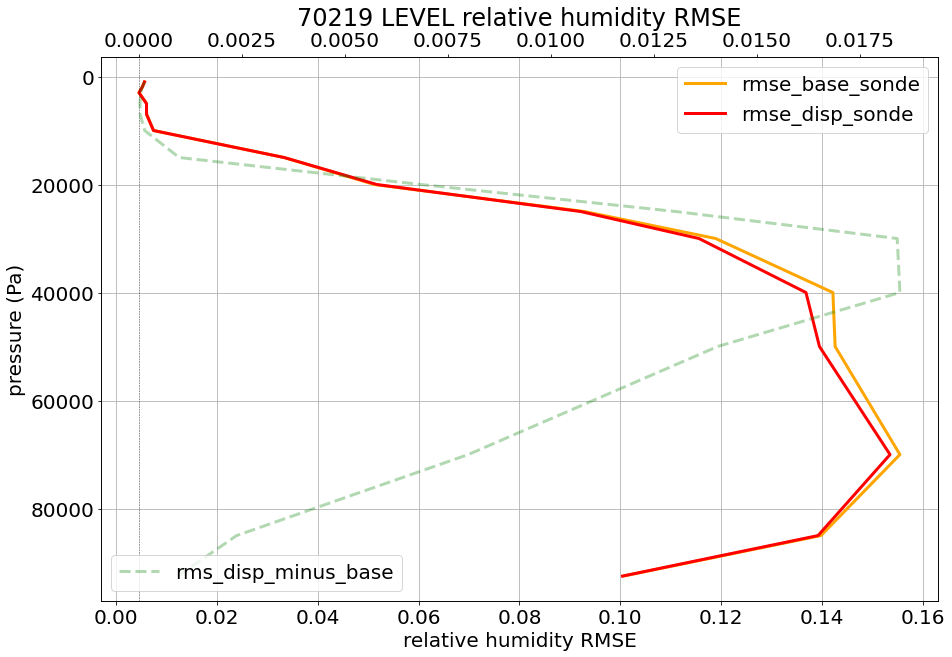

In [7]:
stats = ['70219']
year = 2020
time = [11,12,13]
month = False
trajectory_rmse (stats=stats, year=year, month=month, time=time, show_ascents=False, show_date=False, min_disp=0,compare_to='fc')

compare to:  fc
valid ascents:  348



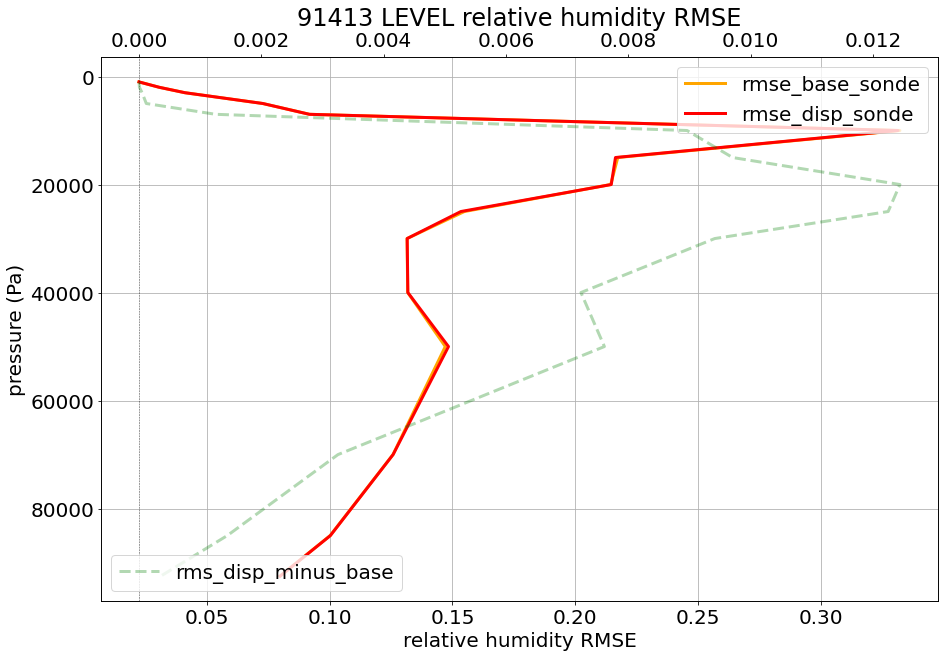

In [8]:
stats = ['91413']
year = 2020
time = [11,12,13]
month = False
trajectory_rmse (stats=stats, year=year, month=month, time=time, show_ascents=False, show_date=False, min_disp=0,compare_to='fc')

compare to:  fc
valid ascents:  366



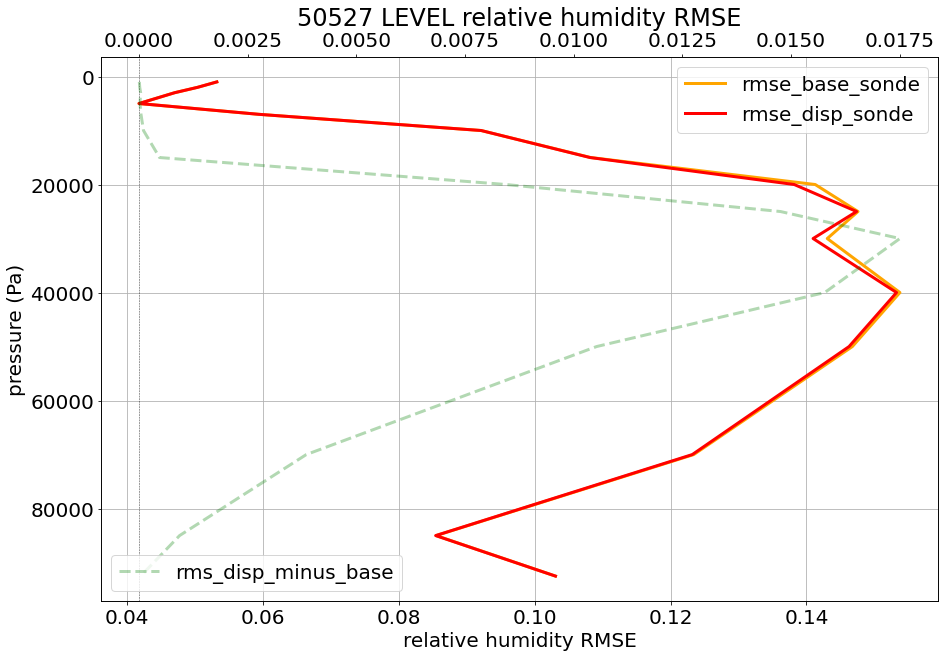

In [9]:
stats = ['50527']
year = 2020
time = [11,12,13]
month = False
trajectory_rmse (stats=stats, year=year, month=month, time=time, show_ascents=False, show_date=False, min_disp=0,compare_to='fc')

compare to:  fc
valid ascents:  351



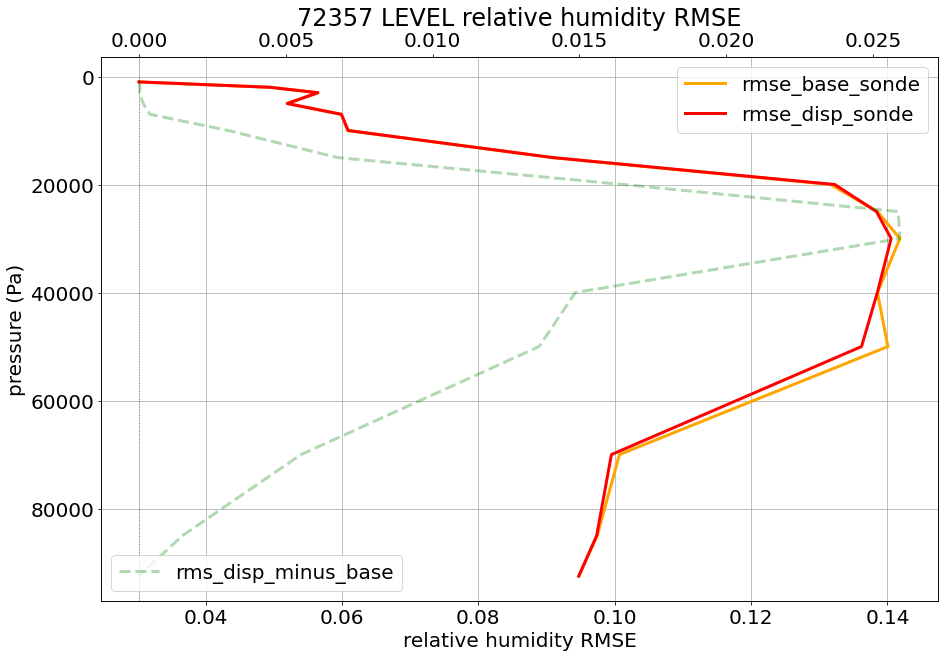

In [10]:
stats = ['72357']
year = 2020
time = [11,12,13]
month = False
trajectory_rmse (stats=stats, year=year, month=month, time=time, show_ascents=False, show_date=False, min_disp=0,compare_to='fc')

# Analysis

compare to:  an
valid ascents:  364



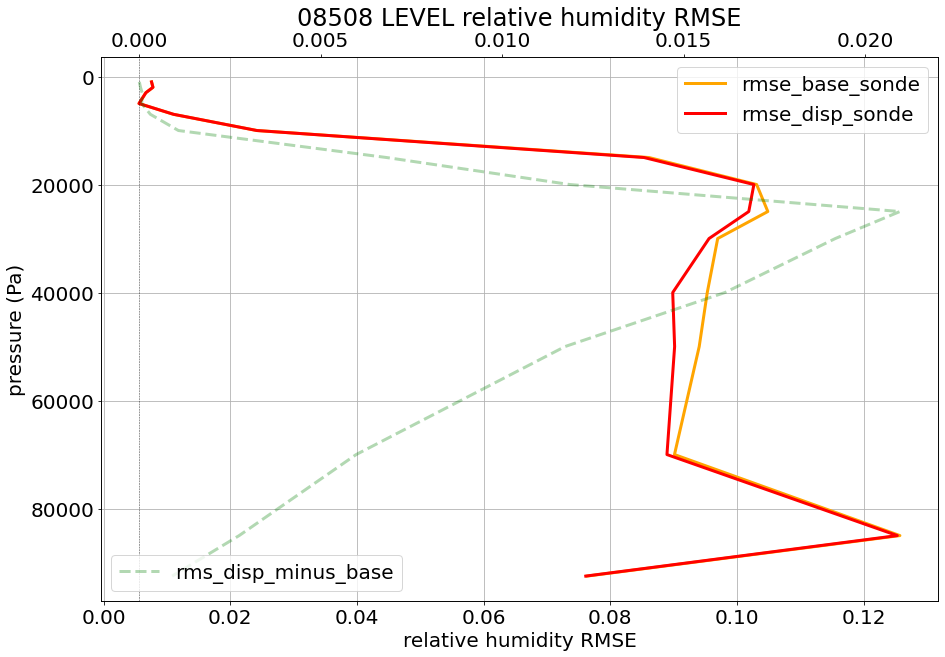

In [11]:
stats = ['08508']
year = 2020
time = [11,12,13]
month = False
trajectory_rmse (stats=stats, year=year, month=month, time=time, show_ascents=False, show_date=False, min_disp=0,compare_to='an')

compare to:  an
valid ascents:  362



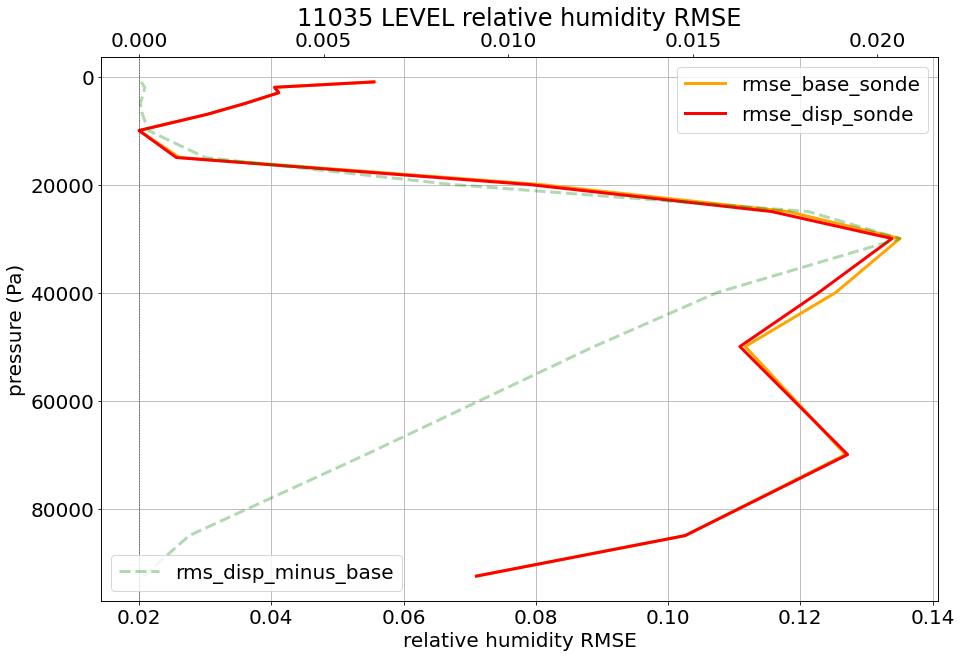

In [12]:
stats = ['11035']
year = 2010
time = [11,12,13]
month = False
trajectory_rmse (stats=stats, year=year, month=month, time=time, show_ascents=False, show_date=False, min_disp=0,compare_to='an')

compare to:  an
valid ascents:  362



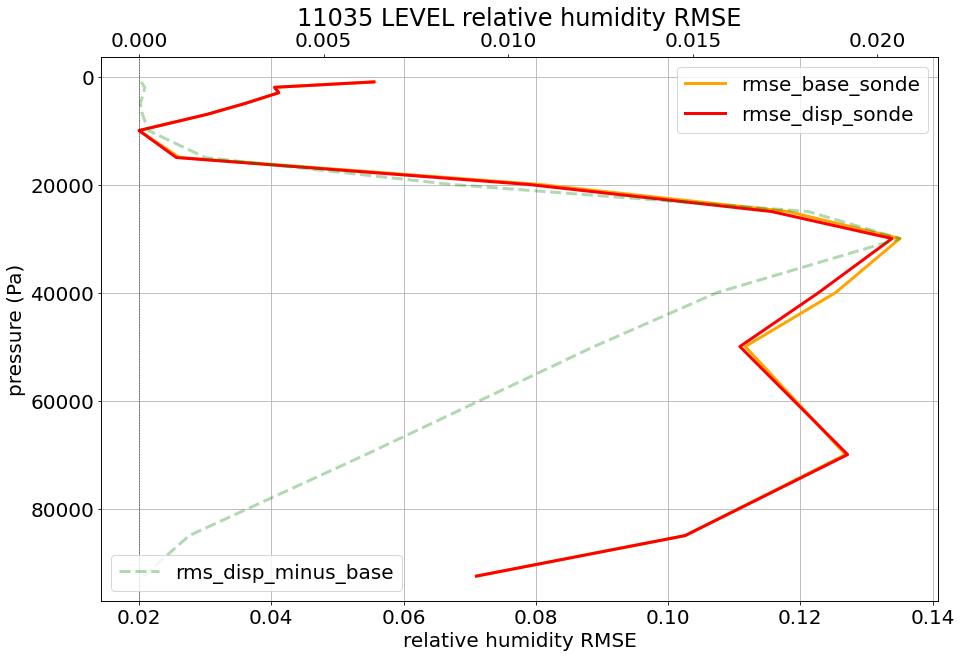

In [13]:
stats = ['11035']
year = 2010
time = [11,12,13]
month = False
trajectory_rmse (stats=stats, year=year, month=month, time=time, show_ascents=False, show_date=False, min_disp=0,compare_to='an')

compare to:  an
valid ascents:  355



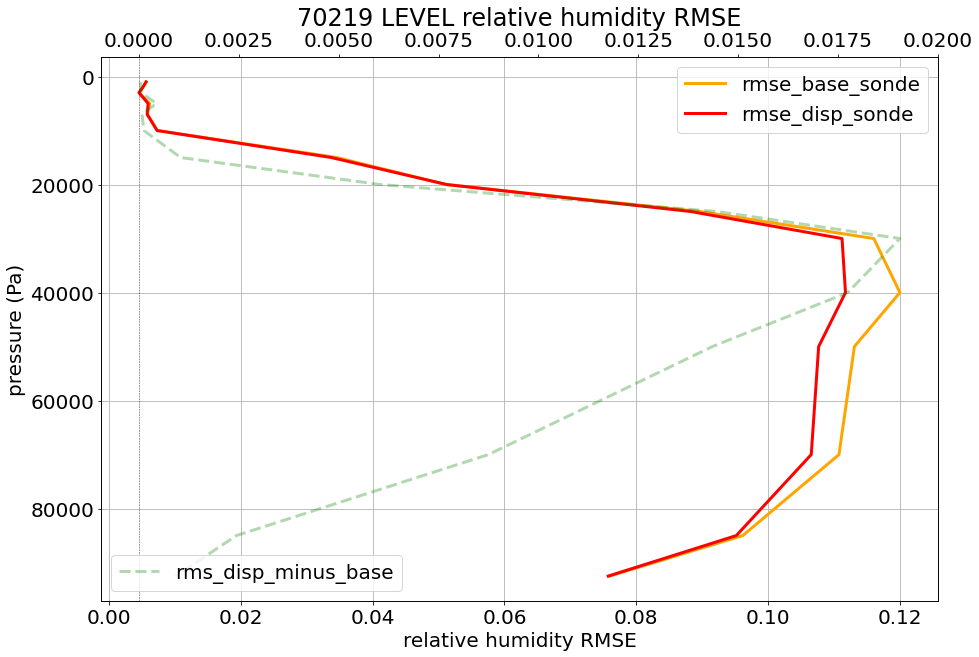

In [14]:
stats = ['70219']
year = 2020
time = [11,12,13]
month = False
trajectory_rmse (stats=stats, year=year, month=month, time=time, show_ascents=False, show_date=False, min_disp=0,compare_to='an')

compare to:  an
valid ascents:  348



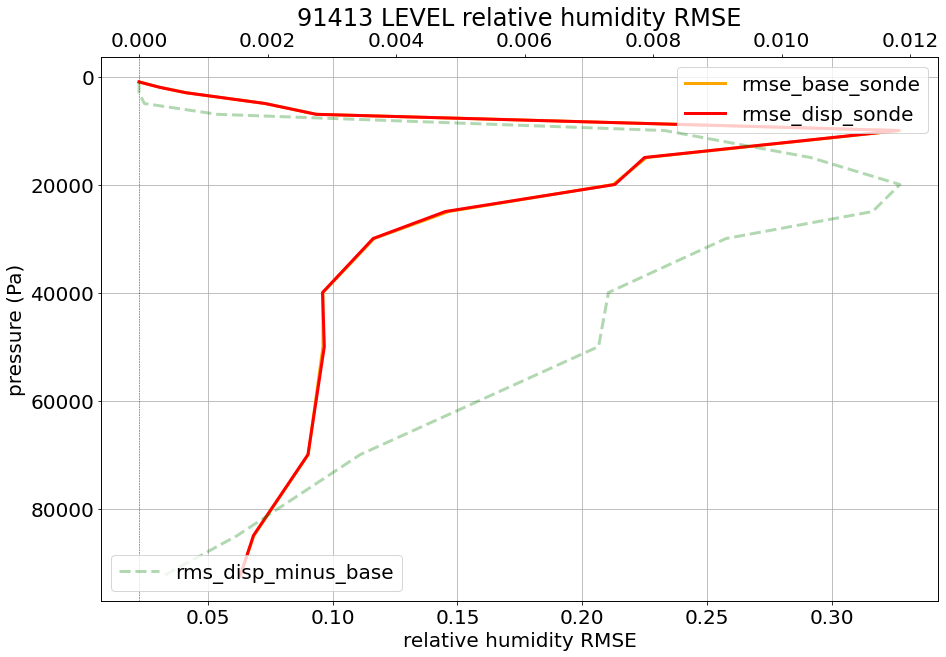

In [15]:
stats = ['91413']
year = 2020
time = [11,12,13]
month = False
trajectory_rmse (stats=stats, year=year, month=month, time=time, show_ascents=False, show_date=False, min_disp=0,compare_to='an')

compare to:  an
valid ascents:  366



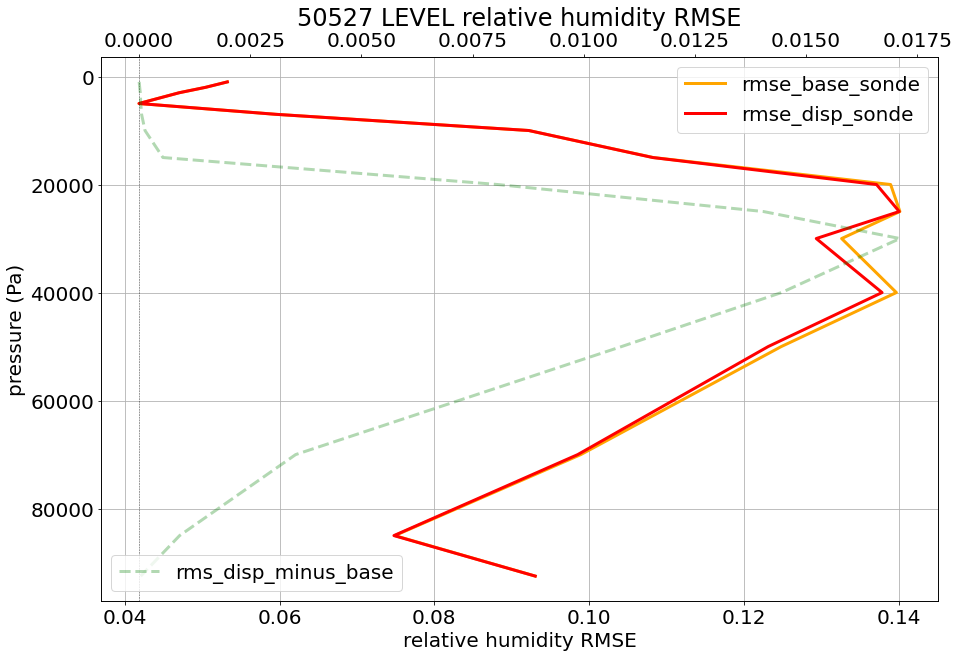

In [16]:
stats = ['50527']
year = 2020
time = [11,12,13]
month = False
trajectory_rmse (stats=stats, year=year, month=month, time=time, show_ascents=False, show_date=False, min_disp=0,compare_to='an')

compare to:  fc
valid ascents:  351



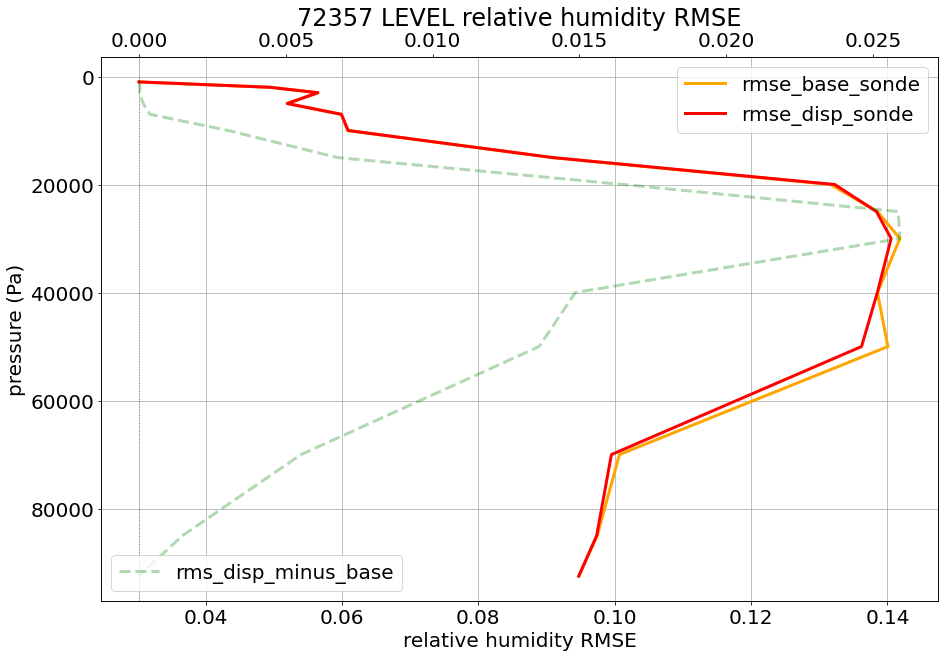

In [17]:
stats = ['72357']
year = 2020
time = [11,12,13]
month = False
trajectory_rmse (stats=stats, year=year, month=month, time=time, show_ascents=False, show_date=False, min_disp=0,compare_to='fc')